# Predicción completa

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import joblib

from datetime import datetime


In [2]:
# Definiciones globales y funciones de transformación

%run D:\Desarrollo\JupyterNotebooks\Modelo_deterioro_tramos_v02\Lib\pandas_options.py
    
%run D:\Desarrollo\JupyterNotebooks\Modelo_deterioro_tramos_v02\Lib\define_constantes.py
    
%run D:\Desarrollo\JupyterNotebooks\Modelo_deterioro_tramos_v02\Lib\fn_transformaciones.py


Fecha y Hora de ejecución de módulo: 2024-08-07 12:30:44


In [3]:
# Cargar archivo de tramos

archivo_tramos = f'{DIRECTORIO_DATOS}/DATOSTRAMOS_2023-08-06.csv'
df_tramos = pd.read_csv(archivo_tramos, low_memory=False)

print(df_tramos.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205754 entries, 0 to 205753
Data columns (total 48 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DIAMETRO    205754 non-null  int64  
 1   CAMARA_CAI  205754 non-null  object 
 2   CONEXIONES  97049 non-null   object 
 3   MATERIAL    205377 non-null  object 
 4   TUBERIA_EL  197356 non-null  object 
 5   VIDA_UTIL   195982 non-null  float64
 6   FABRICANTE  190888 non-null  object 
 7   TIPO_CIMEN  83807 non-null   object 
 8   TIPO_SUELO  65523 non-null   object 
 9   TIPO_RED    205754 non-null  object 
 10  PROF_BATEA  204504 non-null  float64
 11  PROF_BATE1  204369 non-null  float64
 12  COTA_BATEA  202933 non-null  float64
 13  COTA_BATE1  202919 non-null  float64
 14  IPID        205754 non-null  int64  
 15  ESTADO      205754 non-null  object 
 16  GRUPO       205754 non-null  object 
 17  PROPIETARI  205734 non-null  object 
 18  OPERADOR    205512 non-null  object 
 19  EM

In [4]:
# Cargar modelo

archivo_modelo = f'{DIRECTORIO_MODELOS}/LGR-nc.joblib'
modelo = joblib.load(archivo_modelo)
print(modelo)


LogisticRegression(C=5, class_weight={False: 1, True: 2}, max_iter=10000,
                   n_jobs=-1, solver='newton-cholesky')


In [5]:
# Cargar columnas

columnas_modelo = []
archivo_columnas = f'{DIRECTORIO_MODELOS}/COLUMNAS.txt'

with open(archivo_columnas, "r") as archivo:
    for linea in archivo:
        cadena = linea.strip()
        columnas_modelo.append(cadena)

print(columnas_modelo)


['EDAD', 'DIAMETRO', 'LONGITUD', 'AREA', 'PROF_BATEA', 'PROF_BATE1', 'PENDIENTE', 'TIPO_AGUA_COMBINADAS', 'TIPO_AGUA_LLUVIAS Y DESCARGAS', 'TIPO_AGUA_OTRAS', 'MATERIAL_CONCRETO REFORZADO Y OTROS', 'MATERIAL_CONCRETO SIMPLE', 'MATERIAL_PVC', 'FABRICANTE_INDUSTRIAS DIQUE S.A.', 'FABRICANTE_MEXICHEM COLOMBIA S.A.S.', 'FABRICANTE_OTROS', 'ARRANQUE_NO', 'ARRANQUE_SI', 'ZONA_NORTE Y OTRAS', 'ZONA_SUR', 'MUNICIPIO_MEDELLÍN', 'MUNICIPIO_OTRO', 'ESTADO_OPERACION', 'ESTADO_OTRO']


In [6]:
# Generar set de datos

df_predecir = df_tramos.copy()

# Agregar columnas dummy para codificacion
df_predecir['CALIFICACION'] = 1 # Irrelevante, no se usa pero es requerido para transformacion
df_predecir['FECHA_CALIFICACION'] = datetime.now()

X_predecir = tx_codificar(tx_aplicar_transformaciones(df_predecir))

# Agregar columnas faltantes
for col in columnas_modelo:
    if col not in X_predecir.columns:
        print(f'Agregando {col}')
        X_predecir[col] = False

# Reordenar columnas
X_predecir = X_predecir[columnas_modelo]

# Obtener tramos asociados
ipids = df_predecir.loc[df_predecir.index.isin(X_predecir.index)]['IPID']

print(X_predecir.info())
#print(df_ipids.info())

Aplicando transformación: Depurar datos nulos         ... 

D:\Desarrollo\JupyterNotebooks\Modelo_deterioro_tramos_v02\Lib\fn_transformaciones.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columnas_categoricas] = df[columnas_categoricas].fillna('N/D')


Terminada.
Aplicando transformación: Convertir tipo de datos     ... Terminada.
Aplicando transformación: Validar rango de datos      ... Terminada.
Aplicando transformación: Unificar unidades a metros  ... Terminada.
Aplicando transformación: Reasignar tipo de agua      ... Terminada.
Aplicando transformación: Reasignar materiales        ... Terminada.
Aplicando transformación: Reasignar fabricantes       ... Terminada.
Aplicando transformación: Reasignar zonas             ... Terminada.
Aplicando transformación: Reasignar municipios        ... Terminada.
Aplicando transformación: Reasignar estados           ... Terminada.
Aplicando transformación: Agregar edad de tramos      ... Terminada.
Aplicando transformación: Aregar área de tramos       ... Terminada.
Aplicando transformación: Recalcular pendientes       ... Terminada.
Aplicando transformación: Binarizar calificacion      ... Terminada.
Aplicando transformación: Seleccionar columnas útiles ... Terminada.
<class 'pandas.core.fra

In [7]:
# Calcular probabilidades

probabilidades = modelo.predict_proba(X_predecir)
probabilidades_deterioro = probabilidades[:, 1]

df_probabilidades = pd.DataFrame({'IPID': ipids, 'PROBABILIDAD_DETERIORO': probabilidades_deterioro}).sort_values(by='PROBABILIDAD_DETERIORO', ascending=False) 

print(df_probabilidades)


            IPID  PROBABILIDAD_DETERIORO
191199   9357838                0.996213
103920   6240797                0.994234
94880    6228773                0.992553
42681    8513897                0.991646
97036    6226752                0.991552
...          ...                     ...
73029   10125211                0.054966
10531    9952531                0.053629
191359  10015908                0.052049
191215   9870383                0.051281
19411    9284427                0.026490

[187870 rows x 2 columns]


In [ ]:
# Guardar reporte

archivo_predicciones_completo = f'{DIRECTORIO_DATOS}/PREDICCIONES_COMPLETAS.csv'

df_probabilidades.to_csv(archivo_predicciones_completo, index=False)

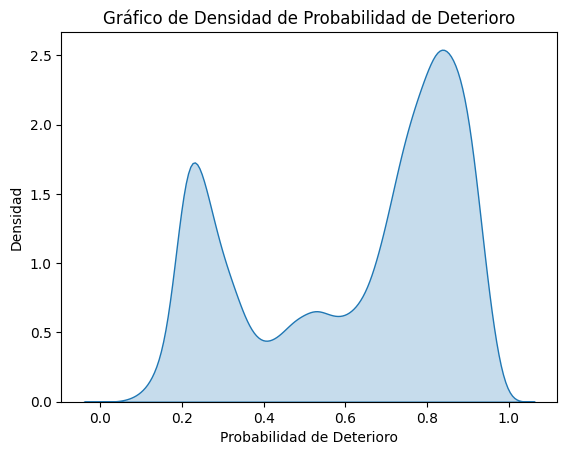

In [8]:
sns.kdeplot(data=df_probabilidades, x='PROBABILIDAD_DETERIORO', fill=True)
plt.xlabel('Probabilidad de Deterioro')
plt.ylabel('Densidad')
plt.title('Gráfico de Densidad de Probabilidad de Deterioro')
plt.show()


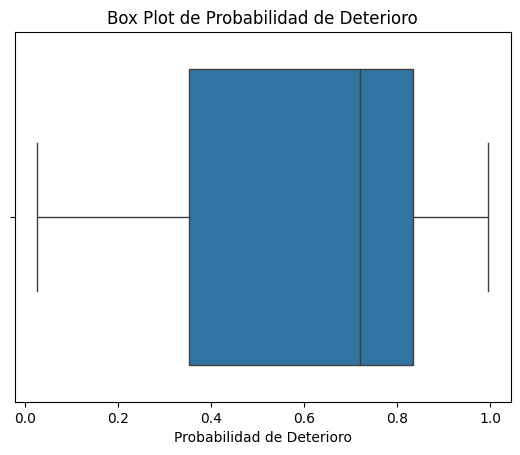

In [9]:
sns.boxplot(data=df_probabilidades, x='PROBABILIDAD_DETERIORO')
plt.xlabel('Probabilidad de Deterioro')
plt.title('Box Plot de Probabilidad de Deterioro')
plt.show()


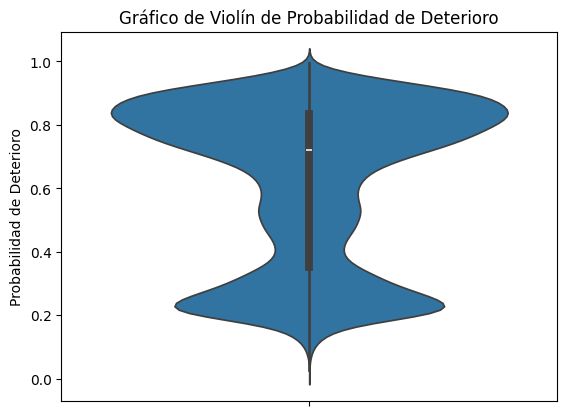

In [10]:
sns.violinplot(data=df_probabilidades, y='PROBABILIDAD_DETERIORO')
plt.ylabel('Probabilidad de Deterioro')
plt.title('Gráfico de Violín de Probabilidad de Deterioro')
plt.show()
